<a href="https://colab.research.google.com/github/NavneethR/Alzheimers-Classification-ViT/blob/main/ViT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating a ViT model

## Load the dataset to google drive


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import zipfile

data_zip = zipfile.ZipFile('/content/drive/MyDrive/Alzheimer\'s dataset.zip')
data_zip.extractall()
data_zip.close()

## Install and load all necessary libraries

In [ ]:
!pip install torch torchvision timm matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Fix: Import the scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import timm
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

## Custom dataset class

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


## Loading and Preprocessing of image

In [ ]:
def load_dataset(folder_path, test_size=0.2, random_state=42):
    image_paths = []
    labels = []
    class_names = os.listdir(folder_path)

    for label, class_name in enumerate(class_names):
        class_path = os.path.join(folder_path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image_paths.append(image_path)
            labels.append(label)

    # Split dataset into train and test sets
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        image_paths, labels, test_size=test_size, random_state=random_state
    )

    # Define transformations with data augmentation
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Create datasets
    train_dataset = ImageDataset(train_paths, train_labels, transform=transform)
    test_dataset = ImageDataset(test_paths, test_labels, transform=transform)

    return train_dataset, test_dataset, class_names


## Create a ViT model

In [ ]:
def create_vit_model(num_classes):
    # Use a smaller ViT model with dropout
    model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=num_classes, drop_rate=0.1)
    return model


## Training the model

In [ ]:
def train_model(model, train_loader, test_loader, num_epochs=15, learning_rate=1e-4, device='cuda'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)  # Add weight decay
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)  # Add scheduler

    # Lists to store metrics
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track metrics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Calculate training metrics
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Evaluate on test set
        test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Adjust learning rate based on test accuracy
        scheduler.step(test_acc)

        # Print stats
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

    # Plot the graphs
    plot_graphs(train_losses, train_accuracies, test_losses, test_accuracies)


## Validation and Evaluation

In [ ]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = 100. * correct / total

    return test_loss, test_acc


In [ ]:
def plot_graphs(train_losses, train_accuracies, test_losses, test_accuracies):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


## Running and Saving the model

In [ ]:
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to: {path}")


In [ ]:

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# Load dataset
folder_path = '/content/AugmentedAlzheimerDataset'  # Replace with your dataset path
train_dataset, test_dataset, class_names = load_dataset(folder_path)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Create ViT model
num_classes = len(class_names)
model = create_vit_model(num_classes)

# Train the model
train_model(model, train_loader, test_loader, num_epochs=10, device=device)

# Save the trained model
model_save_path = "/content/vit_model.pth"
save_model(model, model_save_path)

# Define the directory and file path
save_dir = "/home/navneeth/Documents/Alzheimer's (new)"  # Replace with your desired directory
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
model_save_path = os.path.join(save_dir, "vit_model.pth")

# Save the model
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to: {model_save_path}")

Using device: cpu


NameError: name 'load_dataset' is not defined

# Testing the ViT model


In [ ]:
import timm
import torch

def load_model(path, num_classes, device='cuda'):
    model = timm.create_model('vit_small_patch16_224', pretrained=False, num_classes=num_classes)
    model.load_state_dict(torch.load(path, map_location=device))  # Load weights to the correct device
    model = model.to(device)  # Move the model to the GPU
    model.eval()
    return model


In [ ]:
loaded_model = load_model("/content/vit_model.pth", 4, device="cuda")
print("Model loaded successfully!")

# Verify the loaded model with a dummy input
dummy_input = torch.randn(1, 3, 224, 224).to("cuda")  # Move input to the GPU

with torch.no_grad():
  output = loaded_model(dummy_input)
  print("Model output (logits):", output)


<ipython-input-1-5b61afacdd8b>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device))  # Load weights to the correct d

FileNotFoundError: [Errno 2] No such file or directory: '/content/vit_model.pth'

In [ ]:
from google.colab import files

files.download("/content/vit_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load and preprocess a real image
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F

# Load an image
image_path = "/content/OriginalDataset/VeryMildDemented/26 (60).jpg"  # Replace with your image path
image = Image.open(image_path).convert('RGB')

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Preprocess the image and move to the correct device
input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to GPU

classes = [ "NonDemented","ModerateDemented","MildDemented", "VeryMildDemented"]


Model output (logits): tensor([[-3.3089, -3.7955, -2.5016,  7.6772]], device='cuda:0')
Probabilities: tensor([[1.6934e-05, 1.0409e-05, 3.7961e-05, 9.9993e-01]], device='cuda:0')
Predicted class: VeryMildDemented


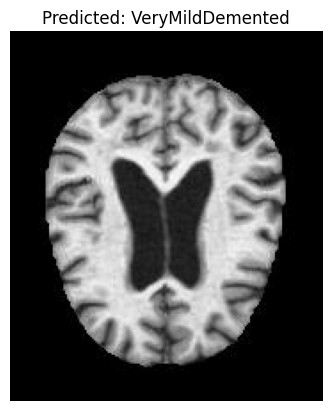

In [ ]:
# Run inference
with torch.no_grad():
    output = loaded_model(input_tensor)  # Use input_tensor, not dummy_input
    print("Model output (logits):", output)

    # Apply softmax to convert logits to probabilities
    probabilities = F.softmax(output, dim=1)
    print("Probabilities:", probabilities)

    # Get the predicted class index
    predicted_class_idx = torch.argmax(probabilities, dim=1).item()

    # Get the predicted class name using the index
    predicted_class = classes[predicted_class_idx]
    print("Predicted class:", predicted_class)

    # Display the image
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Collect predictions and true labels
true_labels = []
predicted_labels = []

# Set the model to evaluation mode
loaded_model.eval()

# Loop through the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass to get the predictions
        outputs = loaded_model(images)

        # Get predicted labels
        _, predicted = torch.max(outputs, 1)

        # Store true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Step 2: Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Step 3: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


NameError: name 'test_loader' is not defined